# Given haloID get
1. halo gas (ICM)
2. thermodynamic profiles (density, temperature, pressure, entropy, metallicity)
3. xray theoretical (emissivity, intensity)
4. xray observational
5. spectrum

In [36]:
pip install yt

Note: you may need to restart the kernel to use updated packages.


In [37]:
pip install regions

Note: you may need to restart the kernel to use updated packages.


In [38]:
pip install pyxsim

Note: you may need to restart the kernel to use updated packages.


In [39]:
import yt
import pyxsim

import h5py
import numpy as np

import os
from regions import RectangleSkyRegion
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy import wcs
from astropy.io import fits

from soxs.utils import soxs_cfg
soxs_cfg.set("soxs", "bkgnd_nH", "0.018") # avoid configparser error by specifying here
import soxs

In [40]:
haloID = 17
snap = "088"
z = 0.05
d = 200
emin = 0.5
emax = 2.0

In [41]:
f_snapshot = f'/home/jovyan/Data/Sims/IllustrisTNG/EX/EX_0/snapshot_{snap}.hdf5'
f_catalog  = f'/home/jovyan/Data/FOF_Subfind/IllustrisTNG/EX/EX_0/groups_{snap}.hdf5'
#f_catalog  = f'/home/jovyan/Data/Sims/IllustrisTNG/EX/EX_0/groups_{snap}.hdf5'

In [42]:
f = h5py.File(f_catalog, 'r')
lentype_h = f['Group/GroupLenType'][:]
r200_all = f['Group/Group_R_Crit200'][:] / 0.6774
Mhalo_all = f['Group/Group_M_Crit200'][:] * 1e10/0.6774
c_all = f['Group/GroupPos'][:]      #19994
f.close()

In [43]:
r200 = r200_all[haloID]
Mhalo = Mhalo_all[haloID]
center = c_all[haloID]

print("R200: ", r200, "kpc")
print("Halo mass: ", np.log10(Mhalo), "Msun")

R200:  332.18805 kpc
Halo mass:  12.549879 Msun


In [44]:
offset = np.sum(lentype_h[:haloID], axis=0)
start = offset[0]
end   = offset[0]+lentype_h[haloID,0]

In [45]:
f = h5py.File(f_snapshot, 'r')

In [46]:
indices = np.arange(start, end)

with h5py.File(f_snapshot, "r") as f_in:
    header_snap = dict(f_in['Header'].attrs)
    parttype0 = f_in["PartType0"]
    keys = list(parttype0.keys())

    filename = f"halo_{haloID}.hdf5"
    with h5py.File(filename, "w") as f_out:
        # Create group for PartType0
        grp = f_out.create_group("PartType0")
        for key in keys:
            data = parttype0[key][indices]
            grp.create_dataset(key, data=data)

        # Create Header group and copy attributes
        header_grp = f_out.create_group('Header')
        header_grp.attrs['NumFilesPerSnapshot'] = 1
        header_grp.attrs['MassTable'] = header_snap['MassTable']
        header_grp.attrs['BoxSize'] = header_snap['BoxSize']
        header_grp.attrs['Time'] = header_snap['Time']
        header_grp.attrs['Redshift'] = header_snap['Redshift']
        gas_count = len(grp['Density'][:])
        header_grp.attrs['NumPart_ThisFile'] = np.array([gas_count,0,0,0,0,0])
        header_grp.attrs['HubbleParam'] = header_snap['HubbleParam']
        header_grp.attrs['Omega0'] = header_snap['Omega0']
        header_grp.attrs['OmegaLambda'] = header_snap['OmegaLambda']
        header_grp.attrs['UnitLength_in_cm'] = header_snap['UnitLength_in_cm']
        header_grp.attrs['UnitMass_in_g'] = header_snap['UnitMass_in_g']
        header_grp.attrs['UnitVelocity_in_cm_per_s'] = header_snap['UnitVelocity_in_cm_per_s']


In [47]:
ds = yt.load(filename)

yt : [INFO     ] 2025-06-21 12:57:04,800 Calculating time from 9.537e-01 to be 4.217e+17 seconds
yt : [INFO     ] 2025-06-21 12:57:04,929 Parameters: current_time              = 4.217393424656435e+17 s
yt : [INFO     ] 2025-06-21 12:57:04,929 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-06-21 12:57:04,930 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-06-21 12:57:04,931 Parameters: domain_right_edge         = [25000. 25000. 25000.]
yt : [INFO     ] 2025-06-21 12:57:04,932 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-06-21 12:57:04,933 Parameters: current_redshift          = 0.04852362998180593
yt : [INFO     ] 2025-06-21 12:57:04,933 Parameters: omega_lambda              = 0.7
yt : [INFO     ] 2025-06-21 12:57:04,934 Parameters: omega_matter              = 0.3
yt : [INFO     ] 2025-06-21 12:57:04,935 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-06-21 12:57:04,935 Parameters: hubble_constant   

In [48]:
def hot_gas(pfilter, data):
    pfilter1 = data[pfilter.filtered_type, "temperature"] > 3.0e5
    pfilter2 = data["PartType0", "StarFormationRate"] == 0.0
    pfilter3 = data["PartType0", "GFM_CoolingRate"] < 0.0
    return (pfilter1 & pfilter2) & pfilter3

yt.add_particle_filter("hot_gas", function=hot_gas,
                       filtered_type='gas', requires=["temperature","density"])

ds.add_particle_filter("hot_gas")

yt : [WARNING  ] 2025-06-21 12:57:04,946 The hot_gas particle filter already exists. Overriding.
yt : [INFO     ] 2025-06-21 12:57:05,006 Allocating for 2.738e+04 particles


True

In [49]:
c = ds.arr(center, "code_length")

yt : [INFO     ] 2025-06-21 12:57:06,827 xlim = 7740.587690 7881.320513
yt : [INFO     ] 2025-06-21 12:57:06,829 ylim = 13297.324995 13438.057818
yt : [INFO     ] 2025-06-21 12:57:06,833 xlim = 7740.587690 7881.320513
yt : [INFO     ] 2025-06-21 12:57:06,833 ylim = 13297.324995 13438.057818
yt : [INFO     ] 2025-06-21 12:57:06,836 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



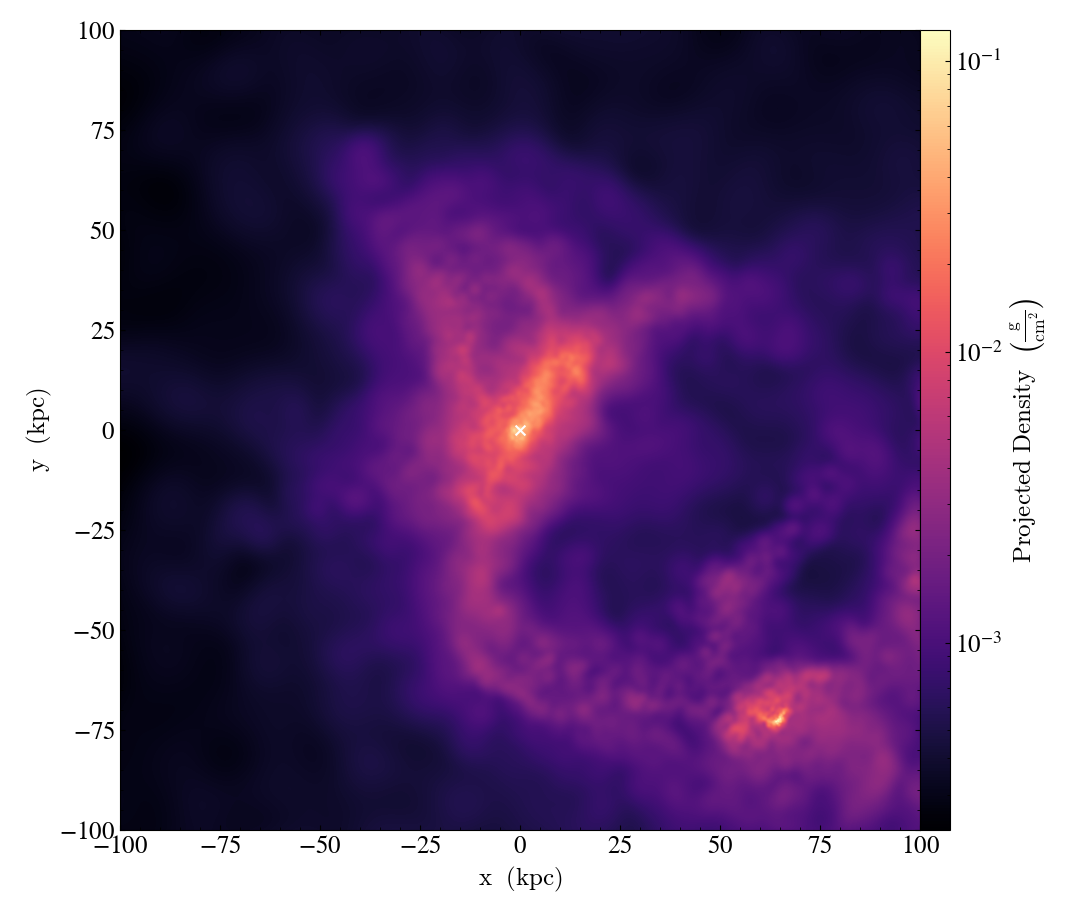

In [50]:
prj = yt.ProjectionPlot(ds, "z", ("gas","density"), width=(d, "kpc"), center=c)
#prj.set_zlim(("gas","density"), 1.0e-4, 1.0)
prj.annotate_marker(c, coord_system='data', color='white',s= 50)
prj.set_cmap(("gas", "density"), "magma")
prj.show()

yt : [INFO     ] 2025-06-21 12:57:14,062 xlim = 7740.587690 7881.320513
yt : [INFO     ] 2025-06-21 12:57:14,063 ylim = 13297.324995 13438.057818
yt : [INFO     ] 2025-06-21 12:57:14,076 xlim = 7740.587690 7881.320513
yt : [INFO     ] 2025-06-21 12:57:14,076 ylim = 13297.324995 13438.057818
yt : [INFO     ] 2025-06-21 12:57:14,078 Making a fixed resolution buffer of (('gas', 'temperature')) 800 by 800
yt : [INFO     ] 2025-06-21 12:57:19,229 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



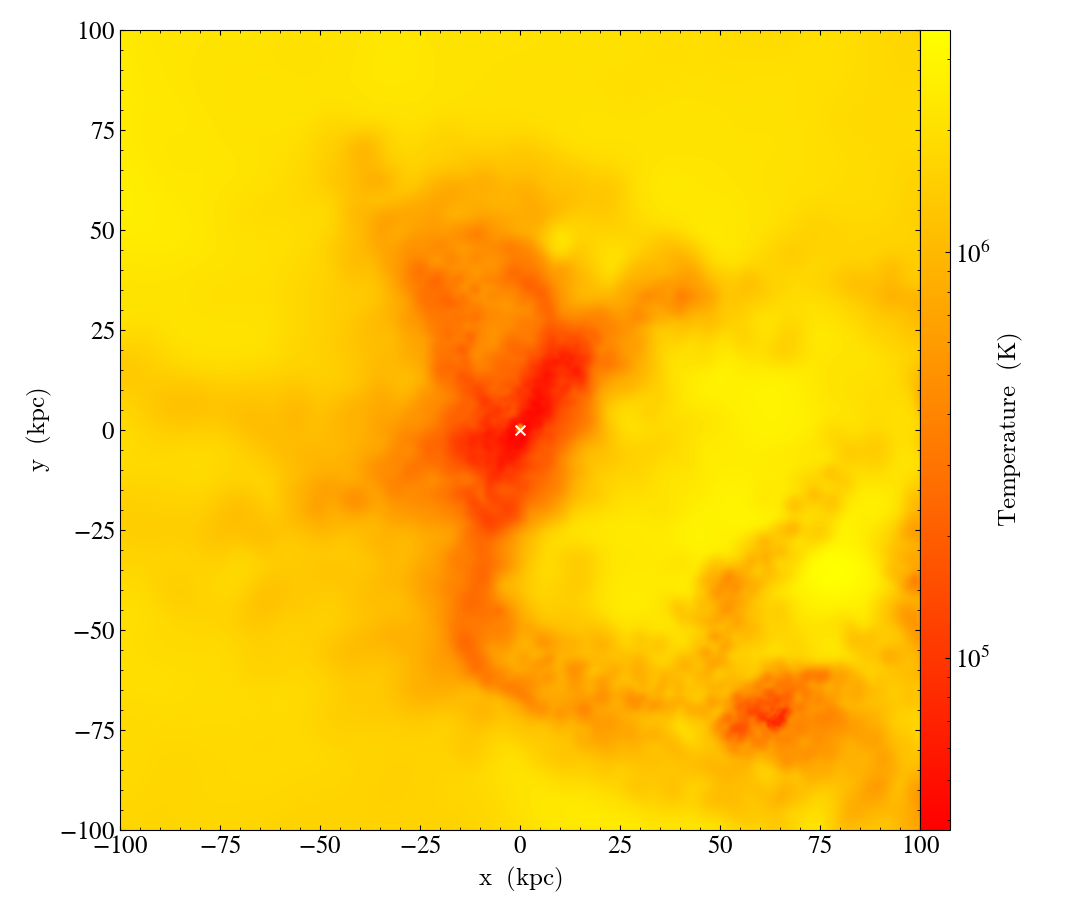

In [51]:
prj = yt.ProjectionPlot(ds, "z", ("gas","temperature"), width=(d, "kpc"), center=c, weight_field=("gas", "density"))
#prj.set_zlim(("gas","density"), 1.0e-4, 1.0)
prj.annotate_marker(c, coord_system='data', color='white',s= 50)
prj.set_cmap(("gas", "temperature"), "autumn")
prj.show()

yt : [INFO     ] 2025-06-21 12:57:25,639 xlim = 7740.587690 7881.320513
yt : [INFO     ] 2025-06-21 12:57:25,640 ylim = 13297.324995 13438.057818
yt : [INFO     ] 2025-06-21 12:57:25,645 xlim = 7740.587690 7881.320513
yt : [INFO     ] 2025-06-21 12:57:25,645 ylim = 13297.324995 13438.057818
yt : [INFO     ] 2025-06-21 12:57:25,647 Making a fixed resolution buffer of (('gas', 'pressure')) 800 by 800
yt : [INFO     ] 2025-06-21 12:57:30,327 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



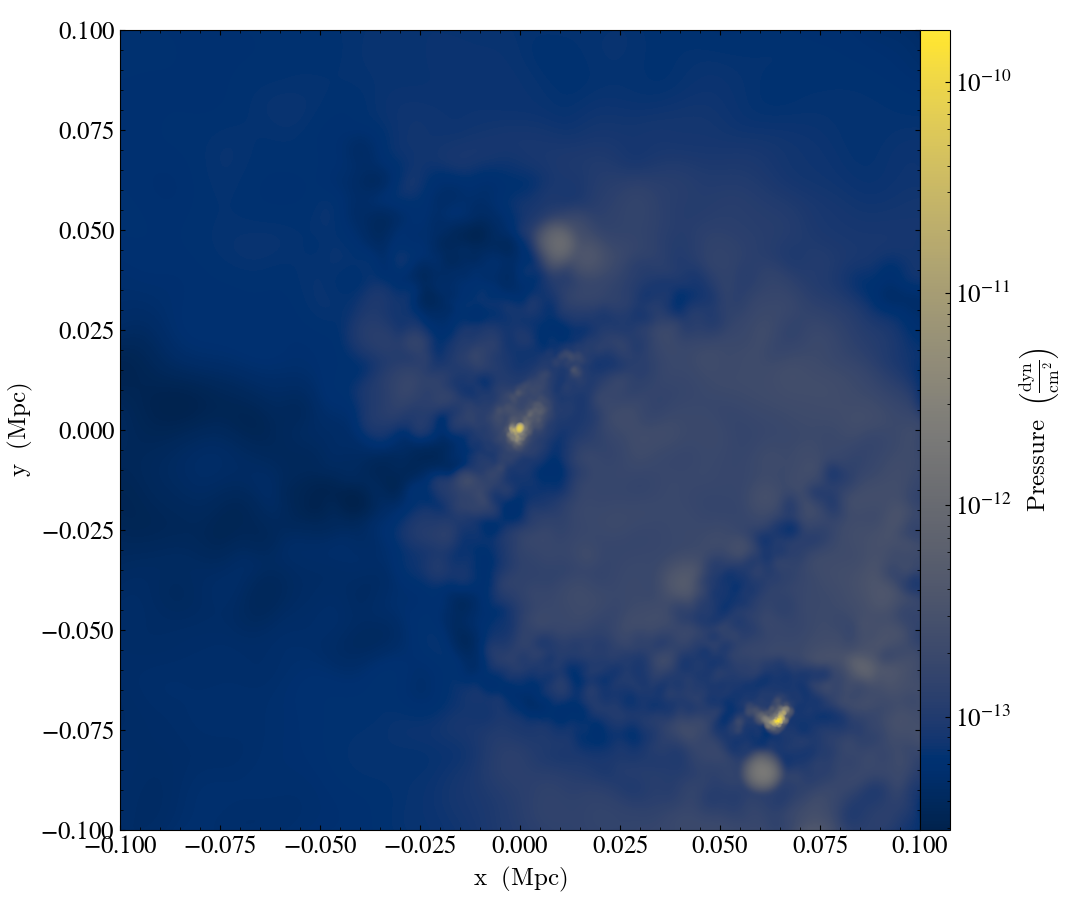

In [52]:
prj = yt.ProjectionPlot(ds, "z", ("gas","pressure"), width=(0.2, "Mpc"), center=c, weight_field=("gas", "density"))
#prj.set_zlim(("gas","density"), 1.0e-4, 1.0)
prj.annotate_marker(c, coord_system='data', color='white',s= 50)
prj.set_cmap(("gas", "pressure"), "cividis")
prj.show()

yt : [INFO     ] 2025-06-21 12:57:37,833 xlim = 7740.587690 7881.320513
yt : [INFO     ] 2025-06-21 12:57:37,835 ylim = 13297.324995 13438.057818
yt : [INFO     ] 2025-06-21 12:57:37,840 xlim = 7740.587690 7881.320513
yt : [INFO     ] 2025-06-21 12:57:37,840 ylim = 13297.324995 13438.057818
yt : [INFO     ] 2025-06-21 12:57:37,842 Making a fixed resolution buffer of (('gas', 'entropy')) 800 by 800
yt : [INFO     ] 2025-06-21 12:57:43,499 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



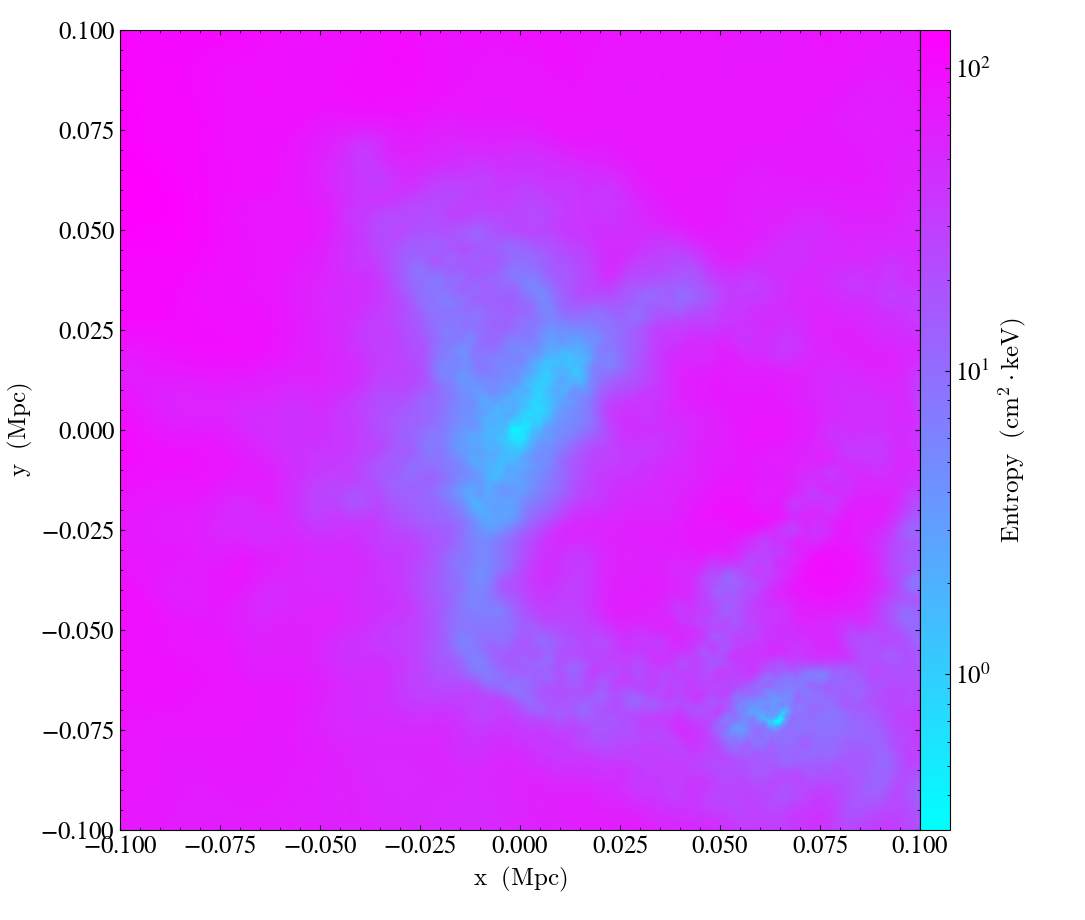

In [53]:
prj = yt.ProjectionPlot(ds, "z", ("gas","entropy"), width=(0.2, "Mpc"), center=c, weight_field=("gas", "density"))
#prj.set_zlim(("gas","density"), 1.0e-4, 1.0)
prj.annotate_marker(c, coord_system='data', color='white',s= 50)
prj.set_cmap(("gas", "entropy"), "cool")
prj.show()

yt : [INFO     ] 2025-06-21 12:57:50,606 xlim = 7740.587690 7881.320513
yt : [INFO     ] 2025-06-21 12:57:50,608 ylim = 13297.324995 13438.057818
yt : [INFO     ] 2025-06-21 12:57:50,613 xlim = 7740.587690 7881.320513
yt : [INFO     ] 2025-06-21 12:57:50,614 ylim = 13297.324995 13438.057818
yt : [INFO     ] 2025-06-21 12:57:50,616 Making a fixed resolution buffer of (('gas', 'metallicity')) 800 by 800
yt : [INFO     ] 2025-06-21 12:57:55,876 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



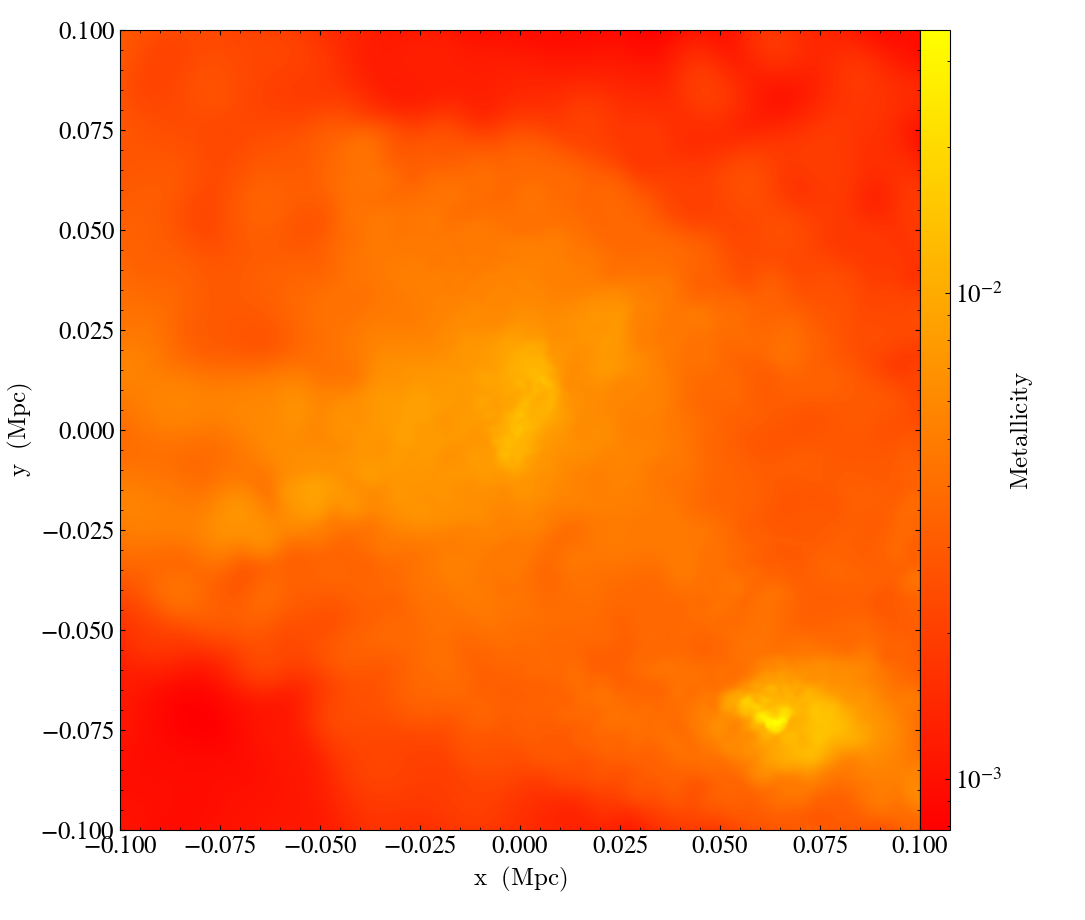

In [54]:
prj = yt.ProjectionPlot(ds, "z", ("gas","metallicity"), width=(0.2, "Mpc"), center=c, weight_field=("gas", "density"))
#prj.set_zlim(("gas","density"), 1.0e-4, 1.0)
prj.annotate_marker(c, coord_system='data', color='white',s= 50)
prj.set_cmap(("gas", "metallicity"), "autumn")
prj.show()

## Theoretical X-ray Maps

In [55]:
nbins = 10000
source_model = pyxsim.CIESourceModel(
    "apec", emin, emax, nbins, ("hot_gas","metallicity"),
    temperature_field=("hot_gas","temperature"),
    emission_measure_field=("hot_gas", "emission_measure"),
)

pyxsim : [INFO     ] 2025-06-21 12:58:04,134 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-06-21 12:58:04,139 kT_max = 64 keV


In [56]:
xray_fields = source_model.make_source_fields(ds, emin, emax)

pyxsim : [INFO     ] 2025-06-21 12:58:04,248 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-06-21 12:58:04,249 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-06-21 12:58:34,896 xlim = 7740.587690 7881.320513
yt : [INFO     ] 2025-06-21 12:58:34,897 ylim = 13297.324995 13438.057818
yt : [INFO     ] 2025-06-21 12:58:34,901 xlim = 7740.587690 7881.320513
yt : [INFO     ] 2025-06-21 12:58:34,902 ylim = 13297.324995 13438.057818
yt : [INFO     ] 2025-06-21 12:58:34,904 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2.0_keV')) 800 by 800



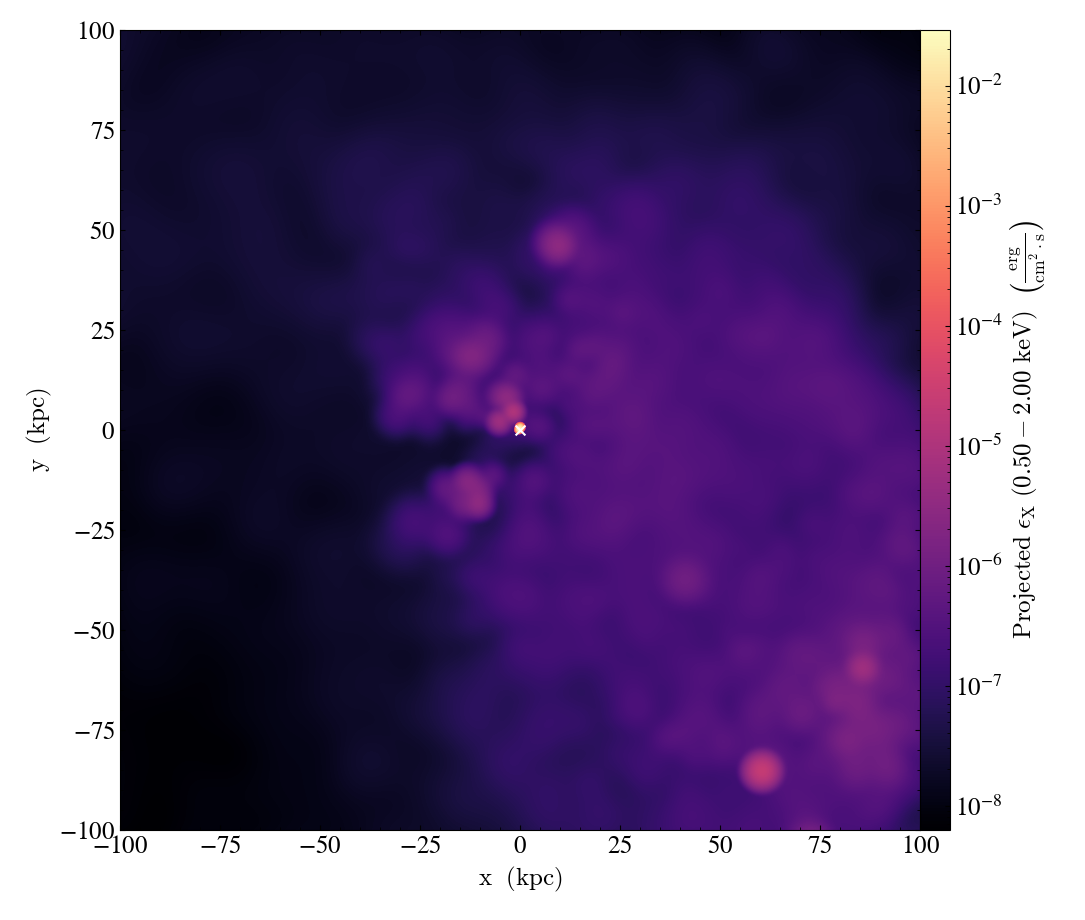

In [57]:
prj = yt.ProjectionPlot(ds, "z", xray_fields[0], width = (d, "kpc"), center = c)
#prj.set_zlim(xray_fields[-2], 1.0e3, 1.0e7)
prj.annotate_marker(c, coord_system='data', color='white',s= 50)

prj.set_cmap(xray_fields[0], "magma")
prj.show()

In [58]:
frb = prj.frb[xray_fields[0]]
data_array = np.array(frb)
np.savetxt("xray_emissiviity.txt", data_array)

In [59]:
xray_fields2 = source_model.make_intensity_fields(ds, emin, emax, redshift=z)

pyxsim : [INFO     ] 2025-06-21 12:58:43,170 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-06-21 12:58:43,172 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-06-21 12:59:11,334 xlim = -70.366411 70.366411
yt : [INFO     ] 2025-06-21 12:59:11,336 ylim = -70.366411 70.366411
yt : [INFO     ] 2025-06-21 12:59:11,337 zlim = -12500.000000 12500.000000
yt : [INFO     ] 2025-06-21 12:59:11,339 Making a fixed resolution buffer of (('hot_gas', 'xray_intensity_0.5_2.0_keV')) 800 by 800



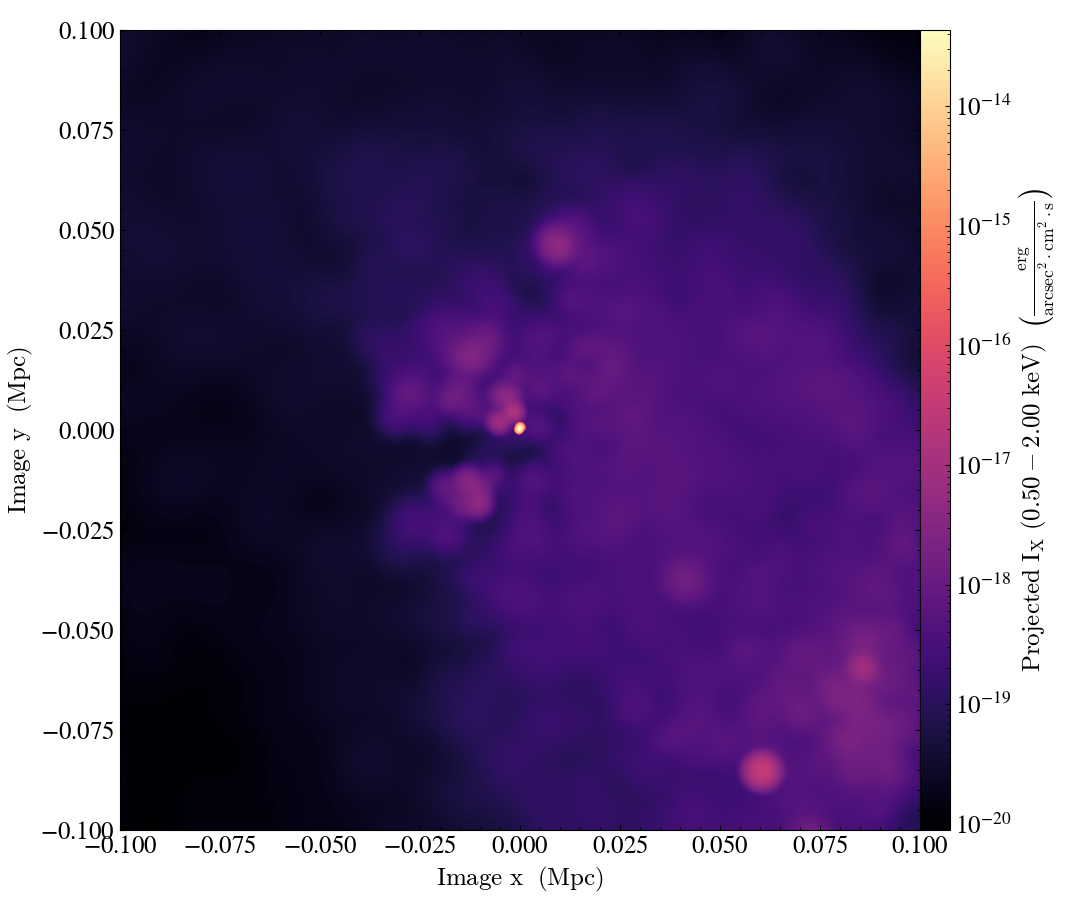

In [60]:
prj = yt.OffAxisProjectionPlot(
    ds, [0.0, 0.0, 1.0], xray_fields2[-2],  # Normal vector along z-axis
    width=(0.2, "Mpc"),
    center=c,
    north_vector=[0.0, 1.0, 0.0]  # Upward direction along y-axis
)
#prj.set_zlim(('gas', f'xray_intensity_{emin}_{emax}_keV'), zmin=1.0e-17, zmax=1.0e-14)
prj.set_cmap(('hot_gas', f'xray_intensity_{emin}_{emax}_keV'), "magma")
prj.annotate_marker(c, coord_system='data', color='white',s= 50)
prj.show()

## Mock Observational Maps

In [61]:
exp_time = (1e6, "s") # exposure time
area = (3000.0, "cm**2") # collecting area
redshift = z

In [62]:
width = ds.quan(1.0, "Mpc")
le = c - 0.5*width
re = c + 0.5*width
box = ds.box(le, re)

In [63]:
n_photons, n_cells = pyxsim.make_photons(f"halo_{haloID}_photons", box, redshift, area, exp_time, source_model)

pyxsim : [INFO     ] 2025-06-21 12:59:19,137 Cosmology: h = 0.6711, omega_matter = 0.3, omega_lambda = 0.7
pyxsim : [INFO     ] 2025-06-21 12:59:19,138 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-06-21 12:59:19,139 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Processing cells/particles :   0%|          | 0/19153 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-06-21 12:59:53,104 Finished generating photons.
pyxsim : [INFO     ] 2025-06-21 12:59:53,106 Number of photons generated: 179793
pyxsim : [INFO     ] 2025-06-21 12:59:53,106 Number of cells with photons: 6798


In [64]:
n_events = pyxsim.project_photons(f"halo_{haloID}_photons", f"halo_{haloID}_events", "z", (45.,30.),
                                  absorb_model="wabs", nH=0.01)

pyxsim : [INFO     ] 2025-06-21 12:59:53,119 Foreground galactic absorption: using the wabs model and nH = 0.01.


Projecting photons from cells/particles :   0%|          | 0/6798 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-06-21 12:59:53,392 Detected 169984 events.


In [65]:
events = pyxsim.EventList(f"halo_{haloID}_events.h5")
events.write_to_simput(f"halo_{haloID}", overwrite=True)

soxs : [WARNING  ] 2025-06-21 12:59:53,567 Overwriting halo_17_phlist.fits.
soxs : [INFO     ] 2025-06-21 12:59:53,721 Writing source 'halo_17' to halo_17_phlist.fits.


## Choosing Instrument

In [66]:
instrument = "lem_outer_array" #"lynx_lxm", "axis", "star-x", "lem_outer_array", "chandra_acisi_cy0", "athena_wfi"
soxs.instrument_simulator(f"halo_{haloID}_simput.fits", f"halo_{haloID}_evt.fits", (1e6, "s"), instrument, (45.,30.), overwrite=True, instr_bkgnd = False, foreground=False, ptsrc_bkgnd=False)

soxs : [INFO     ] 2025-06-21 12:59:53,788 Making observation of source in halo_17_evt.fits.
soxs : [INFO     ] 2025-06-21 12:59:55,348 Detecting events from source halo_17.
soxs : [INFO     ] 2025-06-21 12:59:55,351 Applying energy-dependent effective area from lem_300522.arf.
soxs : [INFO     ] 2025-06-21 12:59:55,370 Pixeling events.
soxs : [INFO     ] 2025-06-21 12:59:55,416 Scattering events with a gaussian-based PSF.
soxs : [INFO     ] 2025-06-21 12:59:55,427 119162 events were detected from the source.
soxs : [INFO     ] 2025-06-21 12:59:55,437 Scattering energies with RMF lem_2.5ev_110422.rmf.


Scattering energies :   0%|          | 0/119162 [00:00<?, ?it/s]

soxs : [INFO     ] 2025-06-21 12:59:57,956 No backgrounds will be added to this observation.
soxs : [INFO     ] 2025-06-21 12:59:57,958 Writing events to file halo_17_evt.fits.
soxs : [INFO     ] 2025-06-21 12:59:58,108 Observation complete.


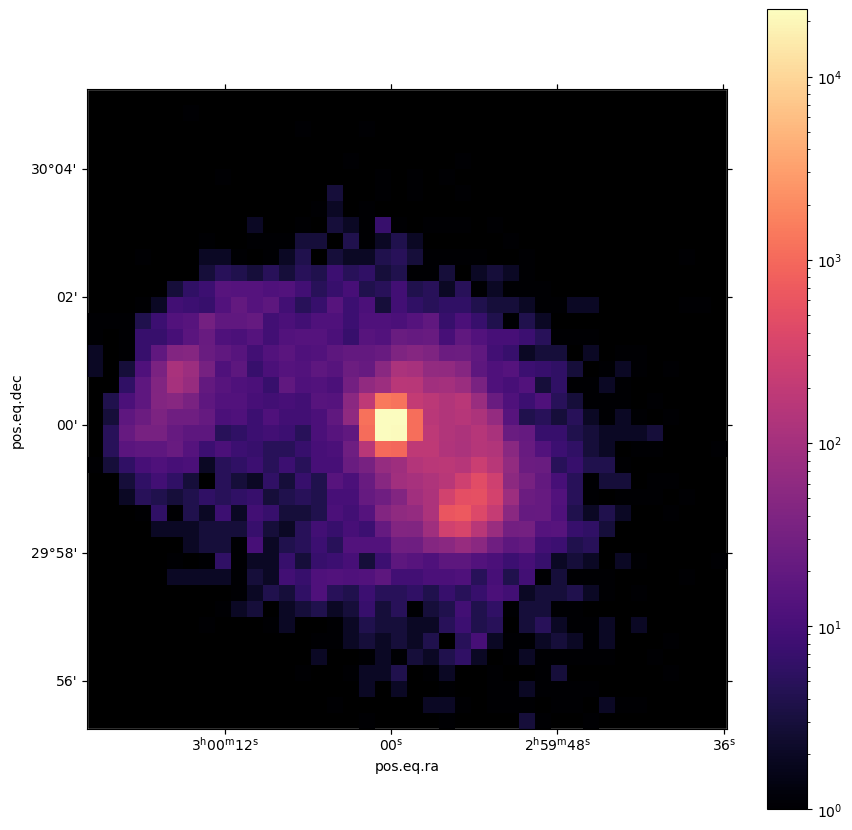

In [67]:
soxs.write_image(f"halo_{haloID}_evt.fits", f"halo_{haloID}_img.fits", emin=emin, emax=emax, reblock=1, overwrite=True)
center_sky = SkyCoord(45, 30, unit='deg', frame='fk5')
region_sky = RectangleSkyRegion(center=center_sky, width=30 * u.arcmin, height=30*u.arcmin)
with fits.open(f"halo_{haloID}_img.fits") as f:
    w = wcs.WCS(header=f[0].header)
    fig, ax = soxs.plot_image(f"halo_{haloID}_img.fits", stretch='log', cmap='magma', width=10/60)
ax.add_artist(region_sky.to_pixel(w).as_artist())
fig.savefig(f"halo_{haloID}_plot.png", dpi=300)

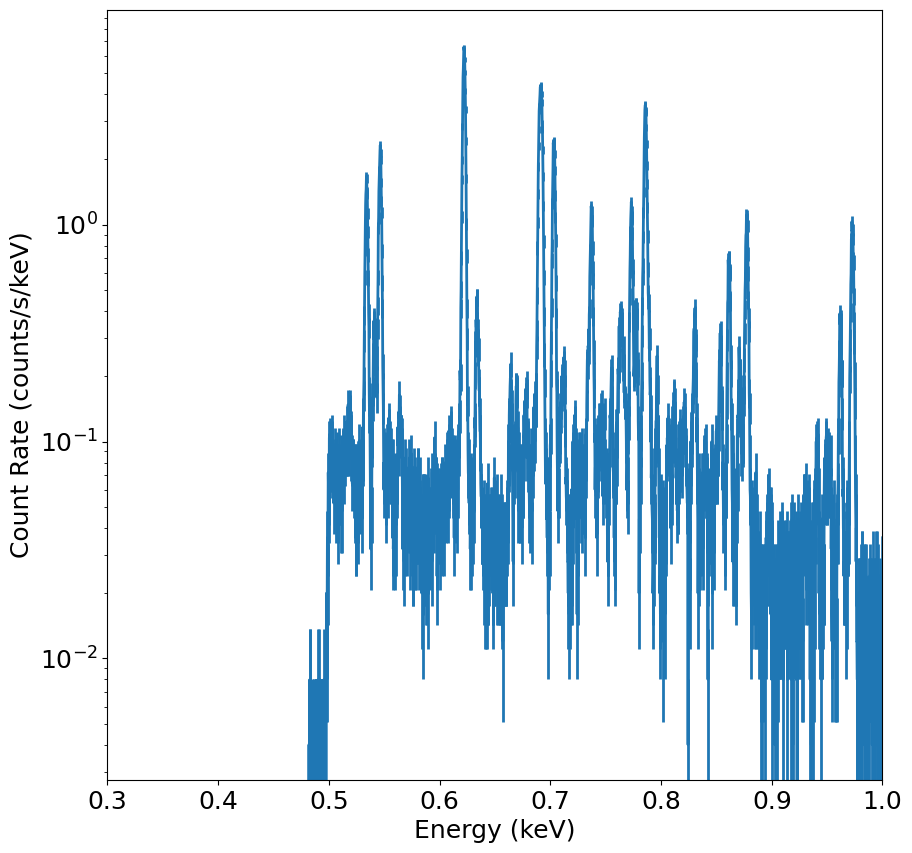

In [68]:
soxs.write_spectrum(f"halo_{haloID}_evt.fits", f"halo_{haloID}_evt.pi", overwrite=True)
fig, ax = soxs.plot_spectrum(f"halo_{haloID}_evt.pi", xmin=0.3, xmax=1.0, xscale="linear")